In [12]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Poisson2D(Problem):
    """
    Solves the 2D Poisson equation
        - u_xx - u_yy = f(x,y)
    on the domain [0,1] with Dirichlet boundary conditions u = 0 on ∂Ω.

    We choose f(x,y) such that the exact solution is:
        u(x,y) = sin(πx)sin(πy)
    which implies f(x,y) = 2π²sin(πx)sin(πy).
    """

    @staticmethod
    def init_params(f_coeff=2 * jnp.pi ** 2, sd=0.1):
        # 'dims': (ud, xd) => u is scalar (ud=1) and x is 2D (xd=2)
        static_params = {
            "dims": (1, 2),
            "f_coeff": f_coeff,  # coefficient in the forcing function f(x,y)
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # --- Physics loss: sample interior points ---
        # x_batch_phys: an array of shape (n_phys, 2)
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, (0, 0)), # u_xx
            (0, (1, 1)), # u_yy
        )

        return [[x_batch_phys, required_ujs_phys],]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, y, tanh = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh
        u = tanh((x)/sd) * tanh((1-x)/sd) * tanh((y)/sd) * tanh((1-y)/sd) * u
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        # --- Physics loss ---
        # For the physics group, the constraints have been replaced with the evaluated quantities:
        # [x_batch_phys, u_xx, u_yy]
        x_phys, u_xx, u_yy = constraints[0]
        x, y = x_phys[:, 0:1], x_phys[:,1:2]

        # Compute the forcing term f(x,y) = 2π² sin(πx) sin(πy)
        f_coeff = all_params["static"]["problem"]["f_coeff"]
        f_val = f_coeff * jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)

        # The physics residual is: u_xx + u_yy + f(x,y)
        phys_residual = u_xx + u_yy + f_val

        return jnp.mean(phys_residual ** 2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        # The exact solution is u(x,y) = sin(πx) sin(πy)
        x, y = x_batch[:, 0:1], x_batch[:,1:2]
        u = jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)
        return u
    

[INFO] 2025-03-30 17:35:53 - <fbpinns.constants.Constants object at 0x7fc89815fcd0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.Poisson2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.7475, 0.7475, 0.7475, 0.7475, 0.7475])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.ChebyshevKAN'>
network_init_kwargs: {'input_dim': 2, 'output_dim': 1, 'degree': 10, 'kind': 1}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((100, 100),)
n_test: (100, 100)
sampler: grid
optimiser: <function adam at 0x7fc9dc6ac900>
optimiser_kwargs: {'learning_rate': 0.01}
seed: 0
summary_freq: 1000
test_freq: 1000
model_save_freq: 10000
show_figures: True
save_figures: False
c

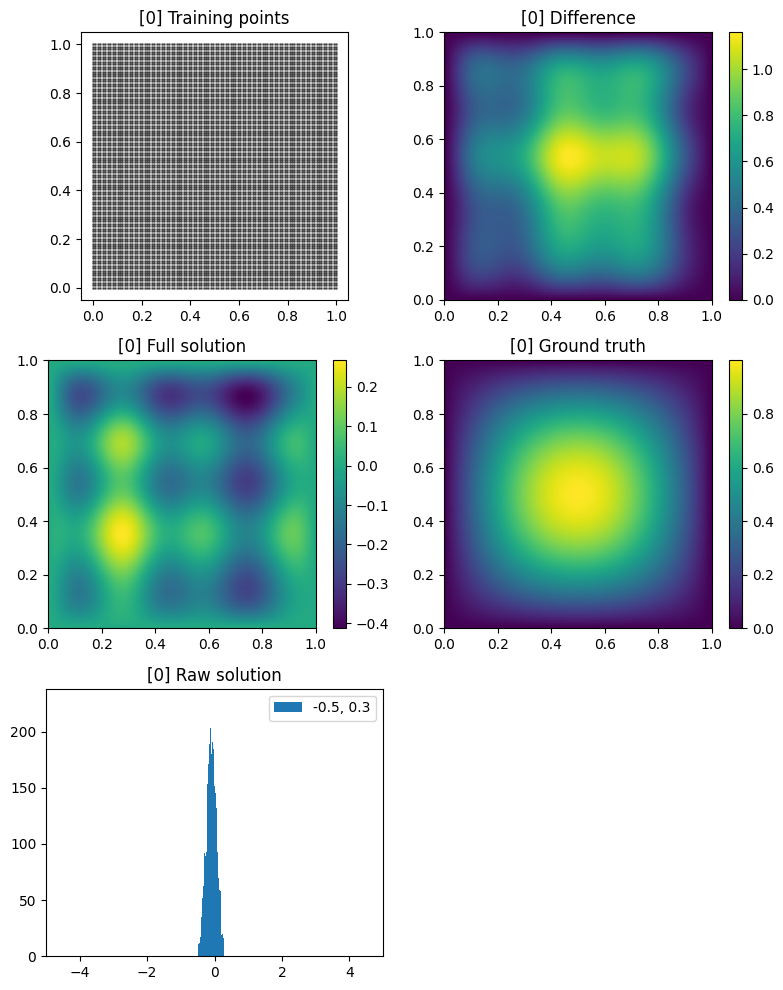

[INFO] 2025-03-30 17:35:55 - [i: 1000/20000] loss: 33.0679 rate: 5133.9 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:56 - [i: 2000/20000] loss: 33.0674 rate: 5049.7 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:56 - [i: 3000/20000] loss: 33.7182 rate: 5126.0 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:56 - [i: 4000/20000] loss: 33.0676 rate: 5207.8 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:56 - [i: 5000/20000] loss: 33.0957 rate: 5184.5 elapsed: 0.00 hr test
(1, 2) 2
True


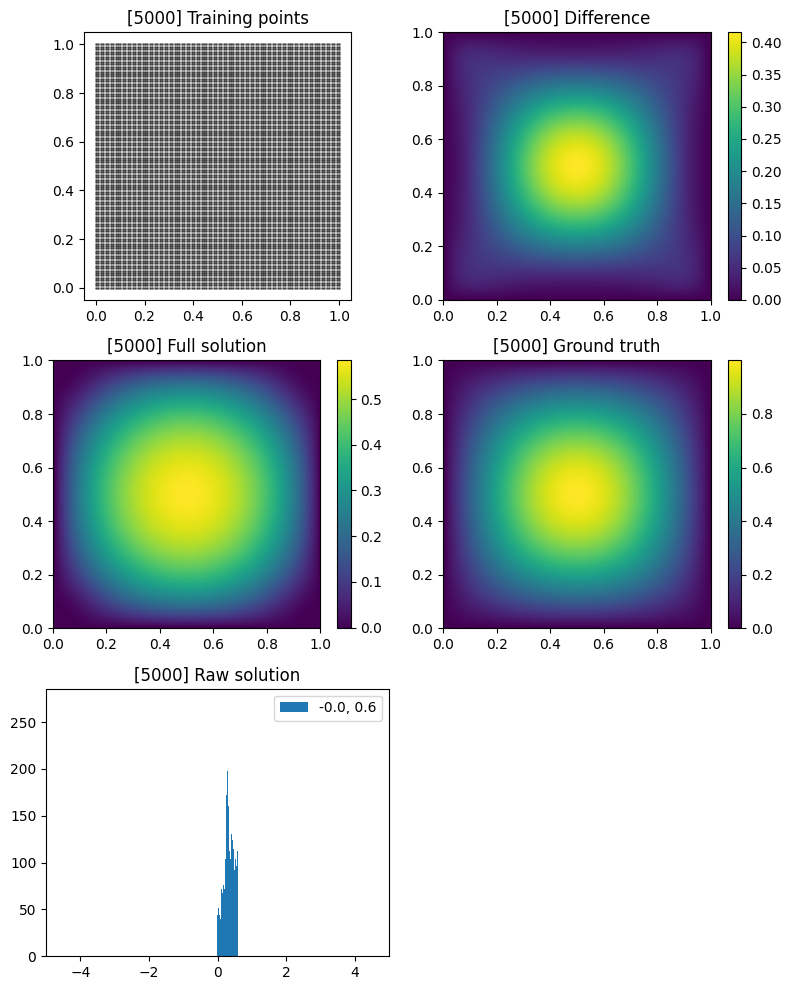

[INFO] 2025-03-30 17:35:57 - [i: 6000/20000] loss: 33.0676 rate: 5238.8 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:57 - [i: 7000/20000] loss: 33.0875 rate: 5092.8 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:57 - [i: 8000/20000] loss: 33.0691 rate: 5063.7 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:58 - [i: 9000/20000] loss: 33.0674 rate: 5049.9 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:58 - [i: 10000/20000] loss: 33.0675 rate: 5065.5 elapsed: 0.00 hr test
(1, 2) 2
True


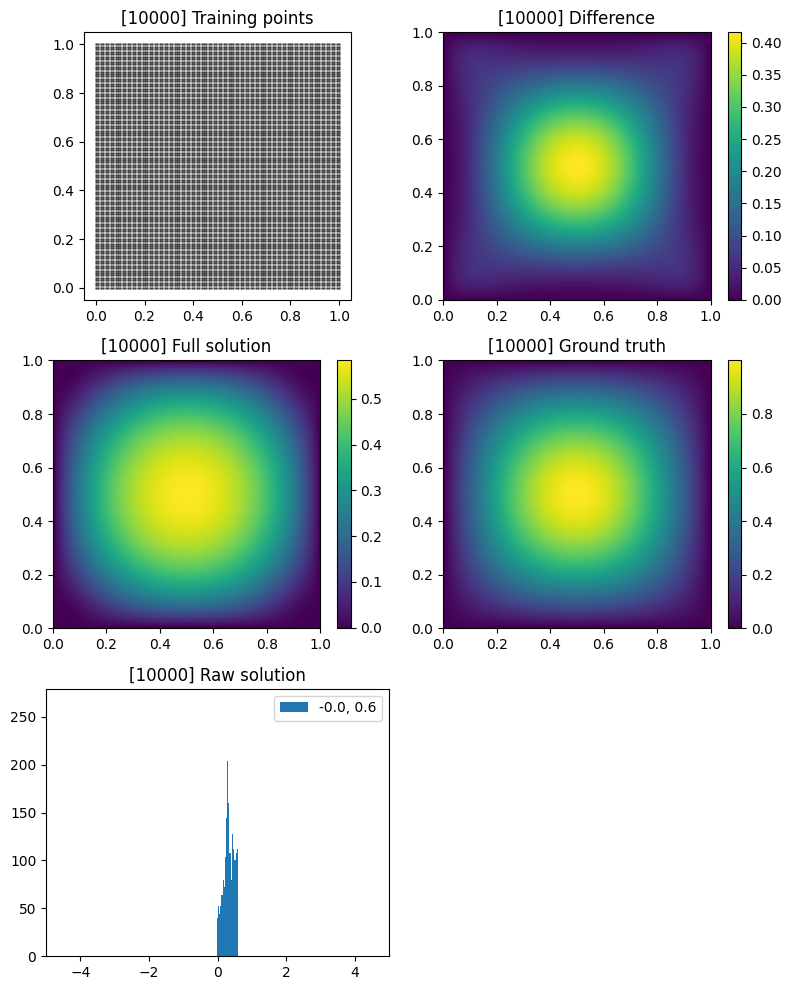

[INFO] 2025-03-30 17:35:59 - [i: 11000/20000] loss: 33.0675 rate: 5200.4 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:59 - [i: 12000/20000] loss: 33.0723 rate: 5264.2 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:59 - [i: 13000/20000] loss: 33.6463 rate: 5215.8 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:59 - [i: 14000/20000] loss: 33.5090 rate: 5177.4 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:35:59 - [i: 15000/20000] loss: 33.0725 rate: 5249.2 elapsed: 0.00 hr test
(1, 2) 2
True


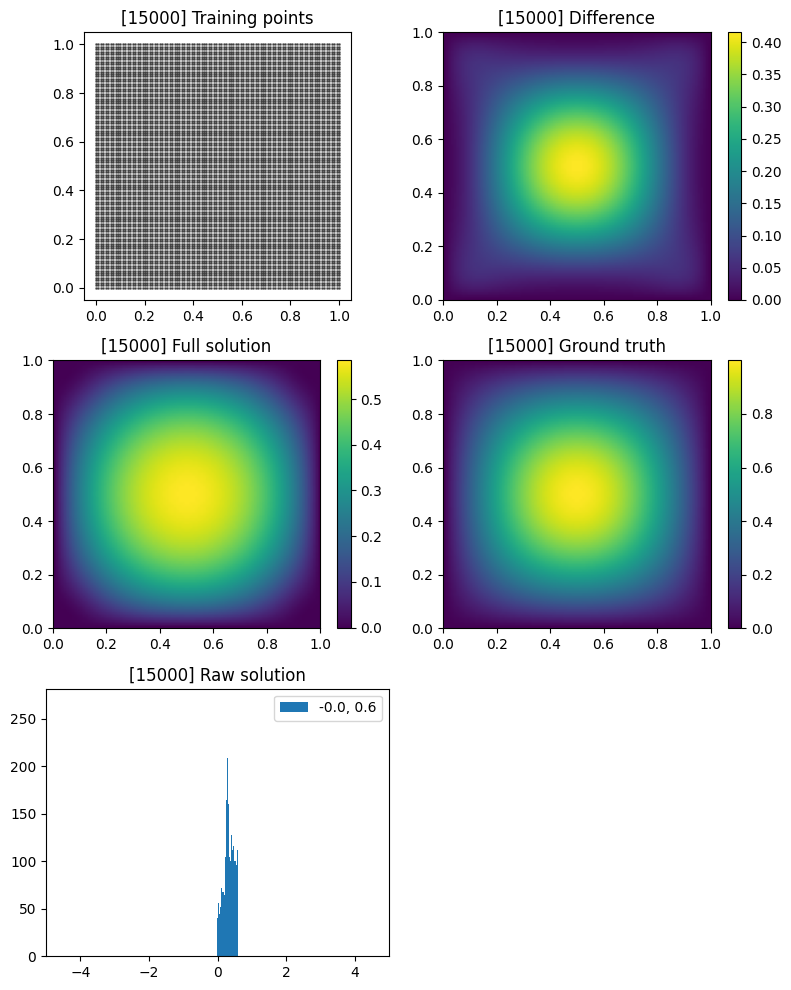

[INFO] 2025-03-30 17:36:00 - [i: 16000/20000] loss: 33.0720 rate: 5223.7 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:36:00 - [i: 17000/20000] loss: 33.0978 rate: 5273.2 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:36:00 - [i: 18000/20000] loss: 33.0795 rate: 5178.7 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:36:01 - [i: 19000/20000] loss: 33.0681 rate: 5256.8 elapsed: 0.00 hr test
[INFO] 2025-03-30 17:36:01 - [i: 20000/20000] loss: 33.2144 rate: 5235.6 elapsed: 0.00 hr test
(1, 2) 2
True


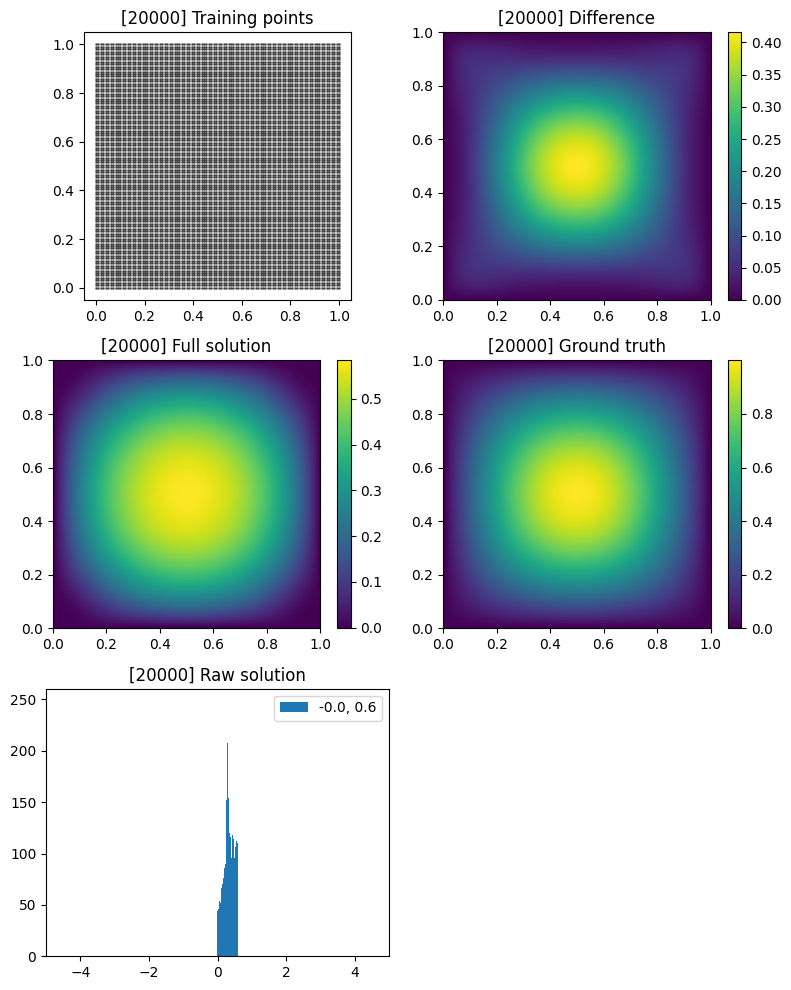

[INFO] 2025-03-30 17:36:01 - [i: 20000/20000] Training complete


In [ ]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import ChebyshevKAN, FCN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer

subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=Poisson2D,
    problem_init_kwargs = dict(),
    # decomposition=RectangularDecompositionND,
    # decomposition_init_kwargs=dict(
    #     subdomain_xs=subdomain_xs,
    #     subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
    #     unnorm=(0., 1.),
    # ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 10, 1),
    # ),
    network=ChebyshevKAN,
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=10,
        kind=1
    ),
    optimiser_kwargs = dict(
        learning_rate=0.01
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    # First element: interior sampling shape for the physics loss (here 200 x 200 points)
    # Second element: boundary sampling shapes; for 2D, we need 4 tuples (one for each boundary)
    ns=((100, 100),),
    # n_test provides the test sampling shape for the interior (here also 200 x 200)
    n_test=(100, 100),
    n_steps=20000,
    clear_output=False,
)

run = FBPINNTrainer(c)
# run = PINNTrainer(c)
all_params = run.train()